# Segmentation d'images CT du foie en 2D

**Objectifs**

<ol>
<li> Apréhender la variabilité des données dans une base d'images médicales
    * Produire une représentation visuelle de la variabilité géométrique
    * Produire une représentation visuelle de la variabilité d'intensité
</li>    
<li> Construire un modèle de réseau et l'entrainer sur la base choisie
    <ol>
        <li>Définir un choix de séparation entre base d'entrainement et base de test</li>
        <li>architecture Unet + entrainement</li>
        <li>Optionnel : architecture Yolo + entrainement</li>
    </ol>
</li>  
<li>    
Tester le modèle choisi et montrer des résultats sur la base de test
</li>
</ol>
     

**Résultats attendus (1 rapport pdf de 4 pages maximum par groupe)**

<ul>
    <li>1 paragraphe décrivant les choix pour l'analyse de variabilité (métriques, ...) </li>
    <li>2 figures résumant l'analyse de la variabilité des données</li>
    <li>1 choix de modèle de Unet avec justification des choix paramétriques</li>
    <li>Quelques résultats de segmentations obtenues avec le/les réseaux entrainés : Dice + illustration</li>
    <li>1 paragraphe de conclusion sur les difficultés rencontrées dans ce travail</li>
</ul>

**Chargement et visualisation des données**

In [1]:
import h5py

import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Tensorflow, Keras and related modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#To save and reload models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import  plot_model


#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
filenameDS = 'db_lits_ds.h5'
fDS = h5py.File(filenameDS, 'r')

In [3]:
seed = 42
random.seed = seed
np.random.seed(seed=seed)

from tensorflow.random import set_seed
set_seed(42)

In [40]:
vol = 3
curVol = fDS[fDS['ds_volumes'][vol]]
print(curVol.shape)

(534, 64, 64)


In [41]:
curLiver = fDS[fDS['ds_livers'][vol]]
print('Shape:', curLiver.shape)
print('Type:', curLiver.dtype)
print('bbmin:', curLiver.attrs['bbmin'])
print('bbmax:', curLiver.attrs['bbmax'])

Shape: (534, 64, 64)
Type: uint8
bbmin: [315   8   7]
bbmax: [469  39  35]


In [42]:
def get_slices_idx(gt):
    bb_z_min = gt.attrs['bbmin'][0]
    bb_zmax = gt.attrs['bbmax'][0]
    slice_range = bb_zmax - bb_z_min
    slice_mid = (bb_zmax + bb_z_min) // 2
    slice_min = slice_mid - slice_range // 8
    slice_max = slice_mid + slice_range // 8

    return slice_min, slice_mid, slice_max


def plot_cur_case(vol_in, gt):

    slice_min, slice_mid, slice_max = get_slices_idx(gt)

    plt.figure(1)
    plt.subplot(2, 3, 1)
    plt.imshow(vol_in[slice_min], cmap='gray')
    plt.subplot(2, 3, 2)
    plt.imshow(vol_in[slice_mid], cmap='gray')
    plt.subplot(2, 3, 3)
    plt.imshow(vol_in[slice_max], cmap='gray')
    #plt.axis('off')
    plt.subplot(2, 3, 4)
    plt.imshow(gt[slice_min], cmap='gray')
    plt.subplot(2, 3, 5)
    plt.imshow(gt[slice_mid]*vol_in[slice_mid], cmap='gray')
    plt.subplot(2, 3, 6)
    plt.imshow(gt[slice_max], cmap='gray')
    plt.show()


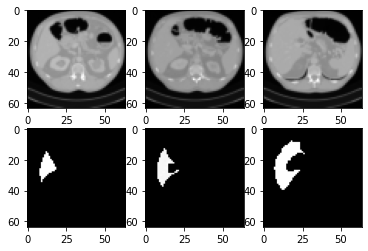

In [43]:
plot_cur_case(curVol, curLiver)

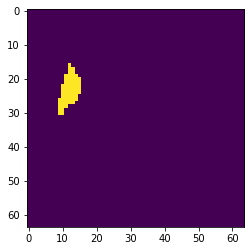

In [48]:
plt.imshow(curLiver[354])

**Analyse de la variabilité selon les métriques choisies**

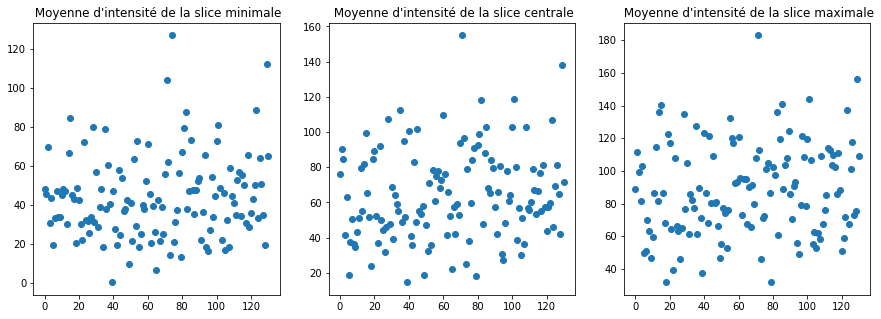

In [8]:
# TO DO from bounding boxes
int_moy_mid = []
int_moy_min = []
int_moy_max = []
for i in range((fDS['ds_volumes']).shape[0]):
    curVol = fDS[fDS['ds_volumes'][i]]
    curLiver = fDS[fDS['ds_livers'][i]]
    slice_min, slice_mid, slice_max = get_slices_idx(curLiver)
    int_moy_mid.append(np.mean(curLiver[slice_mid]*curVol[slice_mid]))
    int_moy_min.append(np.mean(curLiver[slice_min]*curVol[slice_min]))
    int_moy_max.append(np.mean(curLiver[slice_max]*curVol[slice_max]))

plt.figure(figsize = [15,5])
plt.subplot(1, 3, 1)   
plt.plot(int_moy_min, 'o')
plt.title(" Moyenne d'intensité de la slice minimale")
plt.subplot(1, 3, 2)    
plt.plot(int_moy_mid, 'o')
plt.title(" Moyenne d'intensité de la slice centrale")
plt.subplot(1, 3, 3)    
plt.plot(int_moy_max, 'o')
plt.title(" Moyenne d'intensité de la slice maximale")
plt.savefig(" Intensités moyennes ")
plt.show()

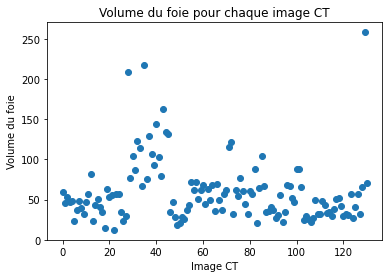

In [9]:
volume=[]
for i in range((fDS['ds_volumes']).shape[0]):
    curLiver = fDS[fDS['ds_livers'][i]]
    sum_total = 0
    for j in range(curLiver.shape[0]):
        sum_total +=np.sum(curLiver[j])
    volume.append(sum_total/curLiver.shape[0])
plt.plot(volume, 'o')
plt.xlabel('Image CT')
plt.ylabel('Volume du foie')
plt.title('Volume du foie pour chaque image CT')
plt.savefig("Volumefou")
plt.show()



 **Definition des données d'entrainement**
 <ul>
    <li>Working image size (x_work = 64, y_work = 64)</li>
    <li>Definir le nombre de données à conserver pour l'evaluation</li>
    <li>Ecrire une fonction qui:
        <ul>
            <li>Sélectionne le quart central des coupes contenant le foie</li>
            <li>Sort les donnees + gt au format (nb_slices_total, x_work, y_work, 1)</li>
            <li>X_data, Y_data = get_train_and_annotation_data(f, x_work, y_work, keep_nb_vol_for_test)</li>    
    

In [49]:
def get_data(x_work, y_work, train_size):
    prev_end = 0
    total = 0
    X_data_train = []
    Y_data_train = []
    
    X_data_test = []
    Y_data_test = []
    
    nbr_persn_train = int(np.round(train_size*(fDS['ds_volumes']).shape[0]))
    
    for i in range(nbr_persn_train):
        curVol = fDS[fDS['ds_volumes'][i]]
        curLiver = fDS[fDS['ds_livers'][i]]
        slice_min, slice_mid, slice_max = get_slices_idx(curLiver)
        
        for j in range(slice_min, slice_max):
            X_data_train.append(curVol[j]) 
            Y_data_train.append(curLiver[j]) 
    
    for i in range(nbr_persn_train+1, fDS['ds_volumes'].shape[0]):
        curVol = fDS[fDS['ds_volumes'][i]]
        curLiver = fDS[fDS['ds_livers'][i]]
        slice_min, slice_mid, slice_max = get_slices_idx(curLiver)
        
        for j in range(slice_min, slice_max):
            X_data_test.append(curVol[j]) 
            Y_data_test.append(curLiver[j]) 
            
    X_data_train = np.array(X_data_train)   
    Y_data_train = np.array(Y_data_train)      
    X_data_test = np.array(X_data_test)   
    Y_data_test = np.array(Y_data_test)
    
    X_data_train = np.expand_dims(X_data_train, axis = 3)   
    Y_data_train = np.expand_dims(Y_data_train, axis = 3)      
    X_data_test = np.expand_dims(X_data_test, axis = 3)   
    Y_data_test = np.expand_dims(Y_data_test, axis = 3)

    return X_data_train, Y_data_train, X_data_test, Y_data_test

(3030, 64, 64, 1)
(3030, 64, 64, 1)
(976, 64, 64, 1)
(976, 64, 64, 1)


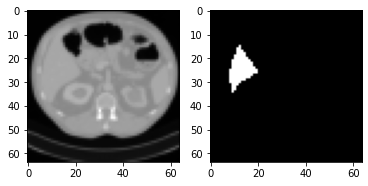

In [50]:
validation_split=0.3
    
x_work = 64
y_work = 64

X_data_train, Y_data_train, X_data_test, Y_data_test = get_data(x_work, y_work, 0.8)
print(X_data_train.shape)
print(Y_data_train.shape)
print(X_data_test.shape)
print(Y_data_test.shape)
plt.subplot(1,2,1)
plt.imshow(X_data_train[45], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Y_data_train[45], cmap='gray')
plt.show()

In [28]:
#Pick central slices from liver annotations
def get_slices_idx(gt):
    bb_z_min = gt.attrs['bbmin'][0]
    bb_zmax = gt.attrs['bbmax'][0]
    slice_range = bb_zmax - bb_z_min
    slice_mid = (bb_zmax + bb_z_min) // 2
    slice_min = slice_mid - slice_range // 8
    slice_max = slice_mid + slice_range // 8

    return slice_min, slice_mid, slice_max

**Construction du UNet et étape de fitting**

You might want to take inspiration from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/

Or for a more linear coding representation https://github.com/zhixuhao/unet/blob/master/model.py

In [51]:
def unet_model_enhanced(img_width=64, img_height=64):
    
    #define the architecture parameters
    n_channels = [16,32,64]  #the number of kernels/feature channels per block SELON TAILLE IMAGE ! 
    #n_channels = [2**i for i in range(4,int(np.log2(img_width)+1))]
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    encoder_list = []
    decoder_list = [] 
    
    initializer = tf.keras.initializers.HeNormal()

    
    
    # Use Keras Input layer to create one
    inp = Input(shape = (img_width,img_height, 1))
    
    # Encoder
    conv_enc = inp
    for i in range(len(n_channels)):                           
        conv_1 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_enc)
        conv_2 = tf.keras.layers.Conv2D(n_channels[i], kernel_size = k_size, activation = "relu", padding='same')(conv_1)
        encoder_list.append(conv_2)
        conv_enc = tf.keras.layers.MaxPool2D(pool_size=(2, 2) , strides = 2)(conv_2) 
        
    # Decoder
    conv_dec = conv_enc
    n_channels.reverse()
    for k in range(len(n_channels)):
        conv_3 = tf.keras.layers.Conv2DTranspose(n_channels[k],kernel_size = k_size, strides=2 , activation = "relu", padding='same')(conv_dec)
        decoder_list.append(conv_3)
        merge = add([conv_3, encoder_list[-k-1]])
        conv_4 = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(merge)
        conv_dec = tf.keras.layers.Conv2D(n_channels[k], kernel_size = k_size, activation = "relu", padding='same')(conv_4)    
        
    # Output  
    outp = tf.keras.layers.Conv2DTranspose(1,kernel_size = k_size , kernel_initializer='glorot_normal',
                                           activation = "sigmoid", padding='same')(conv_dec)
    
    #outp = tf.keras.layers.Dropout(0.2)(outp)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    
    return model



In [52]:
# Set optmizer, loss and metric
optimizer = "adam"
loss      = binary_crossentropy
metrics   = "accuracy"

In [53]:
model = unet_model_enhanced(64, 64)

#summary
model.summary()
#compile the model
model.compile(loss = loss , optimizer = optimizer, metrics=metrics)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 64, 64, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 64, 64, 16)   2320        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_25[0][0]                  
_______________________________________________________________________________________

In [54]:
%%time
# Fit model
epochs = 25

batch_size = 64

history = model.fit(X_data_train, Y_data_train, batch_size=batch_size, epochs=epochs)

Epoch 1/25
48/48 [==============================] - 23s 473ms/step - loss: 1.8530 - accuracy: 0.9102
Epoch 2/25
48/48 [==============================] - 23s 480ms/step - loss: 0.1557 - accuracy: 0.9269
Epoch 3/25
48/48 [==============================] - 23s 480ms/step - loss: 0.0919 - accuracy: 0.9618
Epoch 4/25
48/48 [==============================] - 23s 480ms/step - loss: 0.0738 - accuracy: 0.9691
Epoch 5/25
48/48 [==============================] - 23s 479ms/step - loss: 0.0596 - accuracy: 0.9759
Epoch 6/25
48/48 [==============================] - 23s 480ms/step - loss: 0.0538 - accuracy: 0.9783
Epoch 7/25
48/48 [==============================] - 25s 520ms/step - loss: 0.0548 - accuracy: 0.9777
Epoch 8/25
48/48 [==============================] - 24s 502ms/step - loss: 0.0519 - accuracy: 0.9786
Epoch 9/25
48/48 [==============================] - 23s 487ms/step - loss: 0.0456 - accuracy: 0.9814
Epoch 10/25
48/48 [==============================] - 23s 489ms/step - loss: 0.0441 - accura

In [55]:
model.save_weights('model1_weights.hdf5')

In [59]:

score = model.evaluate(X_data_train, Y_data_train, verbose=0)
print("Train accuracy:", score[1])



Train accuracy: 0.9830287098884583


KeyError: 'val_accuracy'

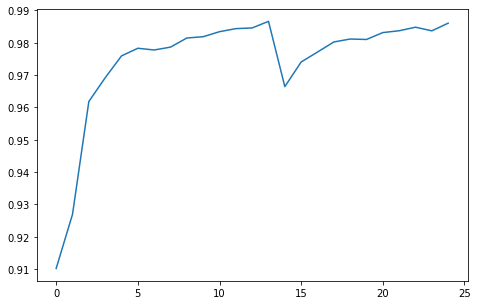

In [61]:
plt.figure(figsize=(17,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1.1])

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation')
plt.plot(history.history['loss'], label='Training')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')

plt.show()

** Tensorboard (lancé à partir d'une invit de commande dans l'environnement du TP, a la racine du folder contenant 'tb_dir'

**Rechargement du réseau et test**

In [62]:
generateTest = False
pickle_test_file = r"dataforTest_2.pickle"
if not generateTest:
    # Loading the objects:
    with open(pickle_test_file, 'rb') as fileptr:
        X_data_test, Y_data_test = pickle.load(fileptr)
else:
    #Mise au format des données de test
    X_data_test, Y_data_test = get_train_and_annotation_data(f, x_work, y_work, last_train_vol+1, nb_total_volumes-1)

FileNotFoundError: [Errno 2] No such file or directory: 'dataforTest_2.pickle'

In [ ]:
from keras.models import model_from_json
load_model = True
if load_model:
    # Model reconstruction from JSON file
    with open('model_architecture.json', 'r') as fileptr:
        loaded_model = model_from_json(fileptr.read())

    # Load weights into the new model
    loaded_model.load_weights('model_weights.h5')

#Test on all test base
out_all_test = loaded_model.predict(X_data_test)

**Analyse des résultats**

In [ ]:
# Define your Dice function
def classic_dice(y_true, y_pred):
    return 2 * (tf.math.reduce_sum(y_true * y_pred) / tf.math.reduce_sum(y_true + y_pred))

In [ ]:
# FILL IN
# Estimate Dice 

**Visualisation des résultats**

In [ ]:
# FILL IN
def plot_img_with_seg(cur_im, cur_out, cur_gt):

In [ ]:
# Visualization of output overlaid on source images
for testidx in range(0, X_data_test.shape[0], 100):
    cur_gt = np.squeeze(Y_data_test[testidx] * 255)
    cur_im = np.squeeze(X_data_test[testidx])
    cur_out = np.squeeze(out_all_test[testidx])
    plot_img_with_seg(cur_im, cur_out, cur_gt)